#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*17.+0.0 #*np.sin(2*np.pi*3*x+.6)

(1000, 2)


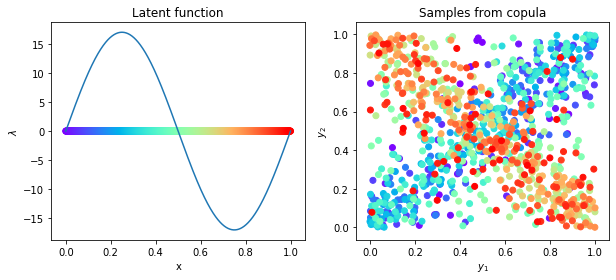

In [29]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(1e3)

X = np.linspace(0.,1.,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

scales = [scale(x) for x in X]
model = FrankCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [30]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [33]:
# define the model (optionally on GPU)
grid_size = 128
#model = GPInferenceModel(train_x, GaussianCopula_Likelihood())#.cuda(device=0)
#likelihood = GaussianCopula_Likelihood()#.cuda(device=0)
model = KISS_GPInferenceModel(FrankCopula_Likelihood(), prior_rbf_length=0.3, grid_size=grid_size).cuda(device=0)

In [34]:
for n,p in model.named_parameters():
    print(n)

variational_strategy.variational_distribution.variational_mean
variational_strategy.variational_distribution.chol_variational_covar
mean_module.constant
covar_module.raw_outputscale
covar_module.base_kernel.raw_lengthscale


In [35]:
# train the model

base_lr = 1e-2
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .1},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .001} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans=0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        #print(output.mean)
        assert torch.all(output.mean==output.mean)
        loss = -mll(output, train_y)  
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}, len: {:.3}, dLoss: {:.3}, \
            mean f: {:.3}, dmean: {:.3}, NaNs/step fixed: {}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), 
                mean_p, np.mean(means[-1]), 
                np.mean(np.abs(1-means[-100]/means[-1])),
                nans/iter_print
            ))
            nans=0
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p < 0.001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step

        loss.backward()
        for par in model.parameters():
            grad = par.grad.data
            nans+=torch.nonzero(grad!=grad).shape[0]
            assert torch.all(grad.abs()!=float('inf'))
            grad[grad!=grad] = 0.0
            par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: inf, len: 0.282, dLoss: 0.0,             mean f: 0.0166, dmean: 1.0, NaNs/step fixed: 0.0


/home/nina/.envs/GPyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in float_scalars


Iter 200/2000 - Loss: inf, len: 0.276, dLoss: nan,             mean f: -0.0399, dmean: 0.181, NaNs/step fixed: 0.0
Iter 300/2000 - Loss: inf, len: 0.272, dLoss: nan,             mean f: -0.0421, dmean: 0.961, NaNs/step fixed: 0.0
Iter 400/2000 - Loss: inf, len: 0.268, dLoss: nan,             mean f: -0.0414, dmean: 0.0212, NaNs/step fixed: 0.0
Iter 500/2000 - Loss: inf, len: 0.263, dLoss: nan,             mean f: -0.0427, dmean: 0.0127, NaNs/step fixed: 0.0


KeyboardInterrupt: 

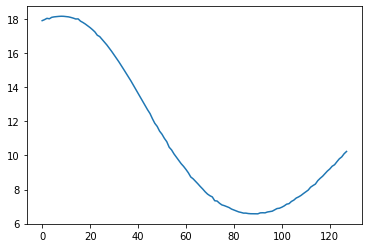

In [18]:
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

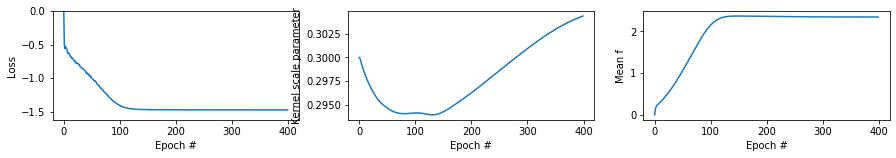

In [19]:
# prot loss function and kernel length
fig, (lossp, kern, mean) = plt.subplots(1,3,figsize=(15,2))
lossp.plot(losses)
lossp.set_xlabel("Epoch #")
lossp.set_ylabel("Loss")
lossp.set_ylim(np.min(losses)*1.1,np.max(losses)*1.1)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [22]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

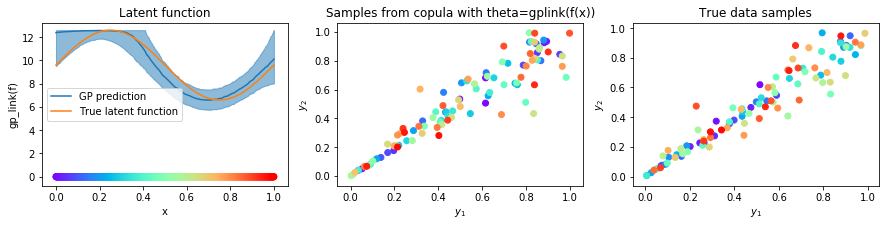

In [23]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
samples = output.rsample(torch.Size([2048]))
F_mean = gplink(samples).mean(0).detach().cpu().numpy()
#F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 10
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()